In [5]:
from collections import defaultdict, Counter, namedtuple
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib
from itertools import combinations, product
import scipy.stats as stats
from os import listdir


In [129]:
#phase_dir = '../phased_ihart.ms2_del'
#twins_file = 'ihart.ms2_del_identicals.txt'           
#sim_file = 'ihart.ms2_del_similarity.txt'           

#phase_dir = '../phased_ihart.ms2_quads_del'
#twins_file = 'ihart.ms2_quads_del_identicals.txt'           
#sim_file = 'ihart.ms2_quads_del_similarity.txt'           

#phase_dir = '../phased_spark_del'
#twins_file = 'spark_del_identicals.txt'           
#sim_file = 'spark_del_similarity.txt'    

#phase_dir = '../phased_spark_quads_del'
#twins_file = 'spark_quads_del_identicals.txt'           
#sim_file = 'spark_quads_del_similarity.txt'  


#phase_dir = '../phased_ssc_del_qs'
#twins_file = 'ssc_del_qs_identicals.txt'           
#sim_file = 'ssc_del_qs_similarity.txt'  

#phase_dir = '../phased_spark_wes_array_quads'
#twins_file = '%s/identicals.txt' % phase_dir          
#sim_file = '%s/similarity.txt' % phase_dir

#phase_dir = '../phased_spark_wes1_array_quads'
#twins_file = '%s/identicals.txt' % phase_dir          
#sim_file = '%s/similarity.txt' % phase_dir


#phase_dir = '../phased_ancestry_quads'
#twins_file = '%s/identicals.txt' % phase_dir          
#sim_file = '%s/similarity.txt' % phase_dir

phase_dir = '../phased_ssc.hg38_pilot_del'
#phase_dir = '../phased_spark_wes1_array_quads_del'
#phase_dir = '../phased_ihart.ms2_quads_del'

#phase_dir = '../phased_mssng_quads_del'

twins_file = '%s/identicals.txt' % phase_dir          
sim_file = '%s/similarity.txt' % phase_dir


In [130]:
# pull sibpairs from phase files
phase_files = [x for x in listdir(phase_dir) if x.endswith('.phased.txt')]
families = []
sibpairs = []
    
for filename in phase_files:
    with open('%s/%s' % (phase_dir, filename), 'r')  as f:
        # parse family
        try:
            header = next(f).strip().split('\t')
            # check that we have a typical nuclear family structure
            if tuple(header[1:5]) == ('m1_del', 'm2_del', 'p1_del', 'p2_del'):
                inds = [header[i][:-4] for i in range(5, len(header)-3, 2)]

                for child1, child2 in combinations(inds[2:], 2):
                    families.append(filename[:-11])
                    sibpairs.append((child1, child2))
        except StopIteration:
            pass
                    
print('sibpairs found', len(sibpairs))

sibpairs found 40


In [131]:

# -------------------------- Load phase data --------------------------
def load_phase_data(phase_dir, chroms, sibpairs):
    mat_match = np.zeros((len(sibpairs),), dtype=int)
    mat_mismatch = np.zeros((len(sibpairs),), dtype=int)
    mat_unknown = np.zeros((len(sibpairs),), dtype=int)
    
    pat_match = np.zeros((len(sibpairs),), dtype=int)
    pat_mismatch = np.zeros((len(sibpairs),), dtype=int)
    pat_unknown = np.zeros((len(sibpairs),), dtype=int)
    
    both_match = np.zeros((len(sibpairs),), dtype=int)
    both_mismatch = np.zeros((len(sibpairs),), dtype=int)
    both_unknown = np.zeros((len(sibpairs),), dtype=int)
    
    has_all_chroms = np.zeros((len(sibpairs),), dtype=bool)
    
    for i, (family, sibpair) in enumerate(zip(families, sibpairs)):
        if i%10==0:
            print(i, end=' ')
        with open('%s/%s.phased.txt' % (phase_dir, family), 'r')  as f:
            # parse family
            try:
                header = next(f).strip().split('\t')
                inds = [header[i][:-4] for i in range(5, len(header)-3, 2)]
                child1_mat_phase_index = 4+2*inds.index(sibpair[0])
                child1_pat_phase_index = 5+2*inds.index(sibpair[0])
                child2_mat_phase_index = 4+2*inds.index(sibpair[1])
                child2_pat_phase_index = 5+2*inds.index(sibpair[1])
                sibpair_chroms = set()

                # pull phase
                for line in f:
                    chrom = line.split('\t', maxsplit=1)[0][3:]
                    if chrom in chroms:
                        sibpair_chroms.add(chrom)
                        pieces = line.strip().split('\t')
                        start_pos, end_pos = [int(x) for x in pieces[-2:]]
                        #start_pos, end_pos = [int(x) for x in pieces[-5:-3]]
                        length = end_pos - start_pos
                        is_hts = int(pieces[-3])==1

                        mat1, mat2 = int(pieces[child1_mat_phase_index+1]), int(pieces[child2_mat_phase_index+1])
                        pat1, pat2 = int(pieces[child1_pat_phase_index+1]), int(pieces[child2_pat_phase_index+1])
                        
                        is_mat_upd = mat1==2 or mat1==3 or mat2==2 or mat2==3 
                        is_pat_upd = pat1==0 or pat1==1 or pat2==0 or pat2==1
                        
                        assert (not is_mat_upd) and (not is_pat_upd)

                        #if mat1==-1 or mat2==-1 or is_hts or is_mat_upd:
                        if mat1==-1 or mat2==-1 or is_mat_upd:
                            mat_unknown[i] += length
                        elif mat1==mat2:
                            mat_match[i] += length
                        else:
                            mat_mismatch[i] += length

                        #if pat1==-1 or pat2==-1 or is_hts or is_pat_upd:
                        if pat1==-1 or pat2==-1 or is_pat_upd:
                            pat_unknown[i] += length
                        elif pat1==pat2:
                            pat_match[i] += length
                        else:
                            pat_mismatch[i] += length
                            
                        #if mat1==-1 or mat2==-1 or pat1==-1 or pat2==-1 or is_hts or is_mat_upd or is_pat_upd:
                        if mat1==-1 or mat2==-1 or pat1==-1 or pat2==-1 or is_mat_upd or is_pat_upd:
                            both_unknown[i] += length
                        elif mat1==mat2 and pat1==pat2:
                            both_match[i] += length
                        else:
                            both_mismatch[i] += length           
                        
            except StopIteration:
                pass
            
            has_all_chroms[i] = len(chroms) == len(sibpair_chroms)
    print('Discarding %d sibpairs missing phased chroms' % np.sum(~has_all_chroms))
    
    mat_scores = mat_match/(mat_match+mat_mismatch)
    pat_scores = pat_match/(pat_match+pat_mismatch)
    both_scores = both_match/(both_match+both_mismatch)
    mat_unknown_fraction = mat_unknown/(mat_match+mat_mismatch+mat_unknown)
    pat_unknown_fraction = pat_unknown/(pat_match+pat_mismatch+pat_unknown)
    
    mat_scores[~has_all_chroms] = -1
    pat_scores[~has_all_chroms] = -1
    both_scores[~has_all_chroms] = -1
                        
    return mat_scores, pat_scores, both_scores, mat_unknown_fraction, pat_unknown_fraction


In [132]:
print('Autosomal genomic similarity')
print(phase_dir)
mat_scores, pat_scores, both_scores, mat_unknown_fraction, pat_unknown_fraction = load_phase_data(phase_dir, set([str(x) for x in range(1, 23)]), sibpairs)


Autosomal genomic similarity
../phased_ssc.hg38_pilot_del
0 10 20 30 Discarding 0 sibpairs missing phased chroms


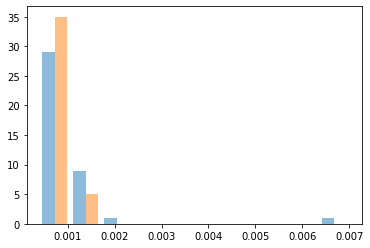

In [133]:
plt.hist([mat_unknown_fraction, pat_unknown_fraction], alpha=0.5)
plt.show()

In [134]:
print('Chromosome-level genomic similarity')
print(phase_dir)
chrom_mat_scores, chrom_pat_scores, chrom_both_scores = [], [], []
chrom_mat_unknown, chrom_pat_unknown = [], []
for chrom in [str(x) for x in range(1, 23)] + ['X']:
    print('chrom', chrom)
    mat, pat, both, mat_unknown, pat_unknown = load_phase_data(phase_dir, set([chrom]), sibpairs)

    # calculate similarity score
    chrom_mat_scores.append(mat)
    chrom_pat_scores.append(pat)
    chrom_both_scores.append(both)
    
    chrom_mat_unknown.append(mat_unknown)
    chrom_pat_unknown.append(pat_unknown)

Chromosome-level genomic similarity
../phased_ssc.hg38_pilot_del
chrom 1
0 10 20 30 Discarding 0 sibpairs missing phased chroms
chrom 2
0 10 20 30 Discarding 0 sibpairs missing phased chroms
chrom 3
0 10 20 30 Discarding 0 sibpairs missing phased chroms
chrom 4
0 10 20 30 Discarding 0 sibpairs missing phased chroms
chrom 5
0 10 20 30 Discarding 0 sibpairs missing phased chroms
chrom 6
0 10 20 30 Discarding 0 sibpairs missing phased chroms
chrom 7
0 10 20 30 Discarding 0 sibpairs missing phased chroms
chrom 8
0 10 20 30 Discarding 0 sibpairs missing phased chroms
chrom 9
0 10 20 30 Discarding 0 sibpairs missing phased chroms
chrom 10
0 10 20 30 Discarding 0 sibpairs missing phased chroms
chrom 11
0 10 20 30 Discarding 0 sibpairs missing phased chroms
chrom 12
0 10 20 30 Discarding 0 sibpairs missing phased chroms
chrom 13
0 10 20 30 Discarding 0 sibpairs missing phased chroms
chrom 14
0 10 20 30 Discarding 0 sibpairs missing phased chroms
chrom 15
0 10 20 30 Discarding 0 sibpairs missin

In [135]:
with open(sim_file, 'w+') as f:
    f.write('\t'.join(['family', 'sibling1', 'sibling2', 'mat_autosomal', 'pat_autosomal', 'matxpat_autosomal', 'mat_unknown', 'pat_unknown'] + \
                      sum([['mat_chrom%s' % chrom, 'pat_chrom%s' % chrom, 'matxpat_chrom%s' % chrom, 'mat_chrom_unknown%s' % chrom, 'pat_chrom_unknown%s' % chrom] for chrom in [str(x) for x in range(1, 23)] + ['X']], [])) + '\n')
    for i, (fam, (sib1, sib2)) in enumerate(zip(families, sibpairs)):
        f.write('\t'.join([fam, sib1, sib2, str(mat_scores[i]), str(pat_scores[i]), str(both_scores[i]), str(mat_unknown_fraction[i]), str(pat_unknown_fraction[i])] + \
                      sum([[str(chrom_mat_scores[j][i]), str(chrom_pat_scores[j][i]), str(chrom_both_scores[j][i]), str(chrom_mat_unknown[j][i]), str(chrom_pat_unknown[j][i])] for j, chrom in enumerate([str(x) for x in range(1, 23)] + ['X'])], [])) + '\n')


In [136]:
identical_pairs = set()
nodentical_pairs = set()
for i, sibpair in enumerate(sibpairs):
    if mat_scores[i] > 0.8 or pat_scores[i] > 0.8:
        identical_pairs.add(sibpair)
    elif mat_scores[i] < 0.2 or pat_scores[i] < 0.2:
        nodentical_pairs.add(sibpair)

In [137]:
with open(twins_file, 'w+') as f:
    for sibpair in identical_pairs:    
        f.write('%s\t%s\tidentical\n' % sibpair)
    for sibpair in nodentical_pairs:    
        f.write('%s\t%s\ttoo different\n' % sibpair)
print('identical', len(identical_pairs), 'nodentical', len(nodentical_pairs))

identical 0 nodentical 0


In [10]:
print(nodentical_pairs)

{('2-0297-003', '2-0297-004')}


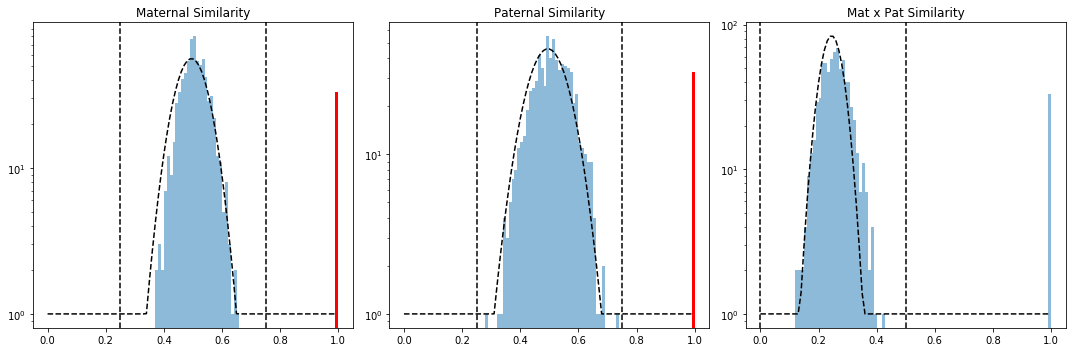

In [11]:
bins = np.arange(0, 1.01, 0.01)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title('Maternal Similarity')
plt.hist(mat_scores, alpha=0.5, bins=bins, log=True)
plt.hist(mat_scores[mat_scores<0.25], color='red', bins=bins, log=True)
plt.hist(mat_scores[mat_scores>0.75], color='red', bins=bins, log=True)

p = 0.5
n = 2*42
model = stats.norm.cdf(bins[1:]*n, n*p, np.sqrt(n*p*(1-p)))-stats.norm.cdf(bins[:-1]*n, n*p, np.sqrt(n*p*(1-p)))
model = model/np.sum(model)
plt.plot(bins[:-1], np.clip(len(mat_scores)*model, 1, None), color='black', linestyle='--')

plt.axvline(0.25, color='black', linestyle='--')
plt.axvline(0.75, color='black', linestyle='--')

plt.subplot(1, 3, 2)
plt.title('Paternal Similarity')
plt.hist(pat_scores, alpha=0.5, bins=bins, log=True)
plt.hist(pat_scores[pat_scores<0.25], color='red', bins=bins, log=True)
plt.hist(pat_scores[pat_scores>0.75], color='red', bins=bins, log=True)

n = 2*28
model = stats.norm.cdf(bins[1:]*n, n*p, np.sqrt(n*p*(1-p)))-stats.norm.cdf(bins[:-1]*n, n*p, np.sqrt(n*p*(1-p)))
model = model/np.sum(model)
plt.plot(bins[:-1], np.clip(len(pat_scores)*model, 1, None), color='black', linestyle='--')

plt.axvline(0.25, color='black', linestyle='--')
plt.axvline(0.75, color='black', linestyle='--')

plt.subplot(1, 3, 3)
plt.title('Mat x Pat Similarity')
plt.hist(both_scores, alpha=0.5, bins=bins, log=True)

n = 2*28 + 2*42
p = 0.25
model = stats.norm.cdf(bins[1:]*n, n*p, np.sqrt(n*p*(1-p)))-stats.norm.cdf(bins[:-1]*n, n*p, np.sqrt(n*p*(1-p)))
model = model/np.sum(model)
plt.plot(bins[:-1], np.clip(len(both_scores)*model, 1, None), color='black', linestyle='--')

plt.axvline(0.0, color='black', linestyle='--')
plt.axvline(0.5, color='black', linestyle='--')

plt.tight_layout()
plt.show()

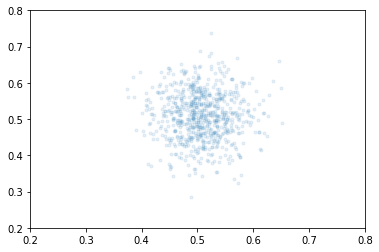

In [12]:
plt.scatter(mat_scores, pat_scores, alpha=0.1, marker='.')
plt.xlim([0.2, 0.8])
plt.ylim([0.2, 0.8])

plt.show()

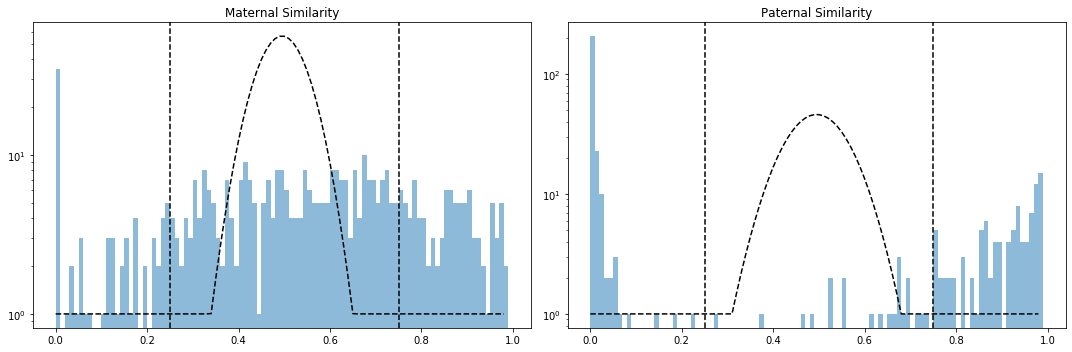

In [13]:
bins = np.arange(0, 1, 0.01)

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.title('Maternal Similarity')
plt.hist(chrom_mat_scores[-1], alpha=0.5, bins=bins, log=True)

p = 0.5
n = 2*42
model = stats.norm.cdf(bins[1:]*n, n*p, np.sqrt(n*p*(1-p)))-stats.norm.cdf(bins[:-1]*n, n*p, np.sqrt(n*p*(1-p)))
model = model/np.sum(model)
plt.plot(bins[:-1], np.clip(len(chrom_mat_scores[-1])*model, 1, None), color='black', linestyle='--')

plt.axvline(0.25, color='black', linestyle='--')
plt.axvline(0.75, color='black', linestyle='--')

plt.subplot(1, 2, 2)
plt.title('Paternal Similarity')
plt.hist(chrom_pat_scores[-1], alpha=0.5, bins=bins, log=True)

n = 2*28
model = stats.norm.cdf(bins[1:]*n, n*p, np.sqrt(n*p*(1-p)))-stats.norm.cdf(bins[:-1]*n, n*p, np.sqrt(n*p*(1-p)))
model = model/np.sum(model)
plt.plot(bins[:-1], np.clip(len(chrom_pat_scores[-1])*model, 1, None), color='black', linestyle='--')

plt.axvline(0.25, color='black', linestyle='--')
plt.axvline(0.75, color='black', linestyle='--')

plt.tight_layout()
plt.show()